# Online fraud detection

#### This project discusses on building the best machine learning algorithms to detect if the transaction is fraud or not (1 indicates fraud)
#### 1) Primary focus will be on correctly identifying the fraud transaction as fraud
#### 2) More than overall accuracy, let us build a model which has the least false negatives (prediction of fraud transaction as not fraud)

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("onlinefraud.csv")
data.drop("isFlaggedFraud", axis=1, inplace=True)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0


In [3]:
# Missing value treatment

data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    1
newbalanceDest    1
isFraud           1
dtype: int64

In [4]:
data.dropna(how='any', inplace=True)
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [5]:
data['isFraud'] = data['isFraud'].astype(int)

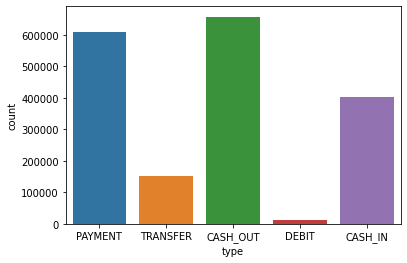

In [6]:
# Data visualization

sns.countplot(x='type', data=data)
plt.show()

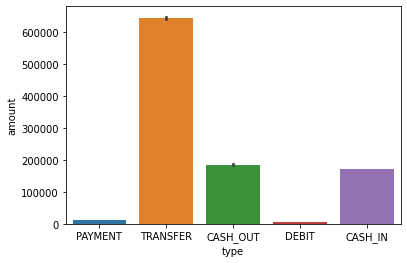

In [7]:
sns.barplot(x='type', y='amount', data=data)
plt.show()

In [8]:
# Splitting the data

x = data.drop("isFraud", axis=1)
y = data["isFraud"]

In [9]:
# Correlation matrix

corr_mat = x.corr()
corr_mat

/tmp/ipykernel_154/2709188919.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = x.corr()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
step,1.000000,0.009920,-0.007915,-0.007319,0.009479,-0.000532
amount,0.009920,1.000000,0.001059,-0.004594,0.214391,0.310118
oldbalanceOrg,-0.007915,0.001059,1.000000,0.999013,0.092490,0.063033
newbalanceOrig,-0.007319,-0.004594,0.999013,1.000000,0.094461,0.062757
oldbalanceDest,0.009479,0.214391,0.092490,0.094461,1.000000,0.983272
newbalanceDest,-0.000532,0.310118,0.063033,0.062757,0.983272,1.000000


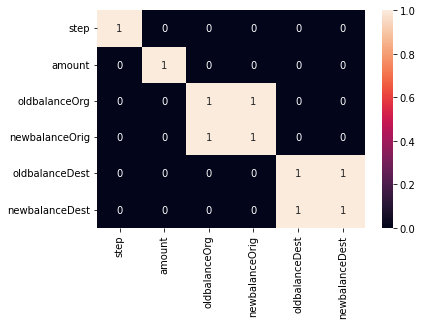

In [10]:
mask = corr_mat.abs() > 0.7

sns.heatmap(mask, annot=True)
plt.show()

In [11]:
# One hot encoding

dummies = pd.get_dummies(data['type'])
data_new = pd.concat([dummies, data], axis=1)
data_new.head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0,0,0,1,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,0,0,0,1,0,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,0,0,0,0,1,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,0,1,0,0,0,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,0,0,0,1,0,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [12]:
x_new = data_new.drop(["type", "isFraud", "nameOrig", "nameDest"], axis=1)
y_new = data_new['isFraud']

In [44]:
# Splitting the data

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x_new, y_new, test_size=0.1, stratify=y_new, random_state=42)

In [45]:
xtrain_sub, xtest_sub, ytrain_sub, ytest_sub = train_test_split(xtest, ytest, test_size=0.3, stratify=ytest, random_state=42)

In [15]:
ytest.value_counts()

0    183053
1       187
Name: isFraud, dtype: int64

#### Note: The main aim of this business case is to classify a fraud as fraud (i.e reduce the False negatives)

#### Model 1 -> Create pipeline to determine the best ML Algo

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [17]:
pipelines = {
    "XGB": make_pipeline(xgb.XGBClassifier(objective='binary:logistic')),
    "LR": make_pipeline(LogisticRegression()),
    "RF": make_pipeline(RandomForestClassifier())
}
# pipelines

In [18]:
hyper_para = {
    "XGB": {
        "xgbclassifier__scale_pos_weight": [500, 1200],
        "xgbclassifier__max_depth": [4,5]
    },
    "LR": {
        "logisticregression__C": [0.1, 1, 10],
    },
    "RF": {
        "randomforestclassifier__max_depth": [4,5]
    }
}

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError

In [20]:
fit_models = {}

for algo, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyper_para[algo], cv=2)
    try:
        print("Started training for {}".format(algo))
        model.fit(xtrain_sub, ytrain_sub)
        best_para = model.best_params_
        fit_models[algo] = model
        print(" {} has been successfully fit".format(algo))
        print(" Best params of", algo, ":", best_para)
    except NotFittedError as e:
        print(repr(e))
        

Started training for XGB
 XGB has been successfully fit
 Best params of XGB : {'xgbclassifier__max_depth': 4, 'xgbclassifier__scale_pos_weight': 500}
Started training for LR
 LR has been successfully fit
 Best params of LR : {'logisticregression__C': 0.1}
Started training for RF
 RF has been successfully fit
 Best params of RF : {'randomforestclassifier__max_depth': 5}


In [21]:
# Testing the models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [22]:
for algo, model in fit_models.items():
    best_model = model.best_estimator_
    yhat = best_model.predict(xtest_sub)
    print("{} accuracy score: {}". format(algo, accuracy_score(ytest_sub, yhat)))
    

XGB accuracy score: 0.9995997962599141
LR accuracy score: 0.9986356690678891
RF accuracy score: 0.9993633122316816


In [23]:
# Further tuning the model fo our requirement -> Reduce the number of false negatives

best_xgb = fit_models['XGB'].best_estimator_
yhat_new = best_xgb.predict(xtest_sub)
print(confusion_matrix(ytest_sub, yhat_new))

[[54902    14]
 [    8    48]]


In [24]:
print(classification_report(ytest_sub, yhat_new))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54916
           1       0.77      0.86      0.81        56

    accuracy                           1.00     54972
   macro avg       0.89      0.93      0.91     54972
weighted avg       1.00      1.00      1.00     54972



In [25]:
ytest_sub.value_counts()

0    54916
1       56
Name: isFraud, dtype: int64

In [26]:
pred_prob = pd.DataFrame(best_xgb.predict_proba(xtest_sub)[:,1])

threshold = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
ypred = pd.DataFrame()

for i in threshold:
    print("for threshold {}".format(i))
    ypred = pred_prob.applymap(lambda x:1 if x>i else 0)
    acc = accuracy_score(ytest_sub, ypred)
    print("Accuracy is {}".format(acc))
    print(confusion_matrix(ytest_sub, ypred))
    print("========================================")

for threshold 0.2
Accuracy is 0.99950884086444
[[54896    20]
 [    7    49]]
for threshold 0.25
Accuracy is 0.9995634141017246
[[54899    17]
 [    7    49]]
for threshold 0.3
Accuracy is 0.9995816051808193
[[54900    16]
 [    7    49]]
for threshold 0.35
Accuracy is 0.9995816051808193
[[54900    16]
 [    7    49]]
for threshold 0.4
Accuracy is 0.9995816051808193
[[54900    16]
 [    7    49]]
for threshold 0.45
Accuracy is 0.9995816051808193
[[54900    16]
 [    7    49]]
for threshold 0.5
Accuracy is 0.9995997962599141
[[54902    14]
 [    8    48]]
for threshold 0.55
Accuracy is 0.999617987339009
[[54903    13]
 [    8    48]]
for threshold 0.6
Accuracy is 0.9996907516553882
[[54907     9]
 [    8    48]]
for threshold 0.65
Accuracy is 0.9997271338135778
[[54909     7]
 [    8    48]]
for threshold 0.7
Accuracy is 0.9997635159717675
[[54911     5]
 [    8    48]]
for threshold 0.75
Accuracy is 0.9997817070508622
[[54912     4]
 [    8    48]]
for threshold 0.8
Accuracy is 0.99978

#### Model 2 -> Resample the data to adjust the imbalanced target feature

In [27]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

x_smote, y_smote = smote.fit_resample(xtrain_sub, ytrain_sub)
y_smote.value_counts()

# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=42)

# x_rus, y_rus = rus.fit_resample(xtrain_sub, ytrain_sub)
# y_rus.value_counts()

0    128137
1    128137
Name: isFraud, dtype: int64

In [28]:
pipelines2 = {
    "XGB": make_pipeline(xgb.XGBClassifier(objective='binary:logistic')),
    "LR": make_pipeline(LogisticRegression()),
    "RF": make_pipeline(RandomForestClassifier())
}

In [29]:
hyper_para2 = {
    "XGB": {
        "xgbclassifier__max_depth": [4,5]
    },
    "LR": {
        "logisticregression__C": [0.1, 1, 10],
    },
    "RF": {
        "randomforestclassifier__max_depth": [4,5]
    }
}

In [30]:
fit_models2 = {}

for algo, pipeline in pipelines2.items():
    model = GridSearchCV(pipeline, hyper_para2[algo], cv=2)
    try:
        print("Started training for {}".format(algo))
        model.fit(x_smote, y_smote)
        best_para = model.best_params_
        fit_models2[algo] = model
        print(" {} has been successfully fit".format(algo))
        print(" Best params of", algo, ":", best_para)
    except NotFittedError as e:
        print(repr(e))

Started training for XGB
 XGB has been successfully fit
 Best params of XGB : {'xgbclassifier__max_depth': 5}
Started training for LR
 LR has been successfully fit
 Best params of LR : {'logisticregression__C': 0.1}
Started training for RF
 RF has been successfully fit
 Best params of RF : {'randomforestclassifier__max_depth': 5}


In [31]:
best_xgb2 = fit_models2['XGB'].best_estimator_
yhat_new = best_xgb.predict(xtest_sub)
print(confusion_matrix(ytest_sub, yhat_new))

[[54902    14]
 [    8    48]]


#### Model 3 -> Ensemble method (Voting classifier)

In [32]:
from sklearn.ensemble import VotingClassifier

rfc = RandomForestClassifier(random_state=42, max_depth=5)
xgb = XGBClassifier(objective='binary:logistic',random_state=42, max_depth=5, scale_pos_weight=1200)
lr = LogisticRegression(C=0.1)

voting = VotingClassifier(estimators=[('rf',rfc),('xgb',xgb),('lr',lr)], voting='soft')

In [33]:
voting.fit(xtrain_sub, ytrain_sub)
ypred3 = voting.predict(xtest_sub)
print(confusion_matrix(ytest_sub, ypred3))

[[54916     0]
 [   23    33]]


In [34]:
pred_prob3 = pd.DataFrame(voting.predict_proba(xtest_sub)[:,1])

threshold = [0.1,0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]

for i in threshold:
    print("for threshold {}".format(i))
    ypred3 = pred_prob3.applymap(lambda x:1 if x>i else 0)
    acc = accuracy_score(ytest_sub, ypred)
    print("Accuracy is {}".format(acc))
    print(confusion_matrix(ytest_sub, ypred3))
    print("========================================")

for threshold 0.1
Accuracy is 0.9997817070508622
[[54818    98]
 [    7    49]]
for threshold 0.2
Accuracy is 0.9997817070508622
[[54870    46]
 [    7    49]]
for threshold 0.3
Accuracy is 0.9997817070508622
[[54899    17]
 [    8    48]]
for threshold 0.35
Accuracy is 0.9997817070508622
[[54913     3]
 [   10    46]]
for threshold 0.4
Accuracy is 0.9997817070508622
[[54916     0]
 [   11    45]]
for threshold 0.45
Accuracy is 0.9997817070508622
[[54916     0]
 [   20    36]]
for threshold 0.5
Accuracy is 0.9997817070508622
[[54916     0]
 [   23    33]]
for threshold 0.55
Accuracy is 0.9997817070508622
[[54916     0]
 [   26    30]]
for threshold 0.6
Accuracy is 0.9997817070508622
[[54916     0]
 [   26    30]]
for threshold 0.65
Accuracy is 0.9997817070508622
[[54916     0]
 [   27    29]]
for threshold 0.7
Accuracy is 0.9997817070508622
[[54916     0]
 [   30    26]]
for threshold 0.75
Accuracy is 0.9997817070508622
[[54916     0]
 [   31    25]]
for threshold 0.8
Accuracy is 0.999

#### Model 4 -> Bagging classifier

In [46]:
from sklearn.ensemble import BaggingClassifier

xgb = XGBClassifier(objective='binary:logistic',random_state=42, max_depth=5, scale_pos_weight=1000)

bag_model = BaggingClassifier(xgb, n_estimators=10, max_samples=0.8, random_state=42)
bag_model.fit(xtrain_sub, ytrain_sub)
ypred4 = bag_model.predict(xtest_sub)
print(confusion_matrix(ytest_sub, ypred4))

[[54912     4]
 [   13    43]]


In [74]:
pred_prob4 = pd.DataFrame(bag_model.predict_proba(xtest_sub)[:,1])

threshold = [0.005,0.1,0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]

for i in threshold:
    print("for threshold {}".format(i))
    ypred4 = pred_prob4.applymap(lambda x:1 if x>i else 0)
    acc = accuracy_score(ytest_sub, ypred4)
    print("Accuracy is {}".format(acc))
    print(confusion_matrix(ytest_sub, ypred4))
    print("========================================")

for threshold 0.005
Accuracy is 0.9966710325256494
[[54734   182]
 [    1    55]]
for threshold 0.1
Accuracy is 0.9995452230226297
[[54895    21]
 [    4    52]]
for threshold 0.2
Accuracy is 0.9997453248926726
[[54906    10]
 [    4    52]]
for threshold 0.3
Accuracy is 0.9997817070508622
[[54910     6]
 [    6    50]]
for threshold 0.35
Accuracy is 0.9998362802881466
[[54914     2]
 [    7    49]]
for threshold 0.4
Accuracy is 0.9998544713672415
[[54915     1]
 [    7    49]]
for threshold 0.45
Accuracy is 0.9998544713672415
[[54915     1]
 [    7    49]]
for threshold 0.5
Accuracy is 0.9998544713672415
[[54915     1]
 [    7    49]]
for threshold 0.55
Accuracy is 0.9998362802881466
[[54915     1]
 [    8    48]]
for threshold 0.6
Accuracy is 0.9998362802881466
[[54916     0]
 [    9    47]]
for threshold 0.65
Accuracy is 0.9997817070508622
[[54916     0]
 [   12    44]]
for threshold 0.7
Accuracy is 0.9997453248926726
[[54916     0]
 [   14    42]]
for threshold 0.75
Accuracy is 0.9

#### Cross validate to confirm the model-4

In [75]:
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

for train_index, test_index in cv.split(xtest, ytest):
    xtrain_fold, xtest_fold = xtest.iloc[train_index], xtest.iloc[test_index]
    ytrain_fold, ytest_fold = ytest.iloc[train_index], ytest.iloc[test_index]
    
    # bag_model.fit(xtrain_fold, ytrain_fold)
    # ypred_fold = bag_model.predict(xtest_fold)
    
    pred_prob = pd.DataFrame(bag_model.predict_proba(xtest_fold)[:,1])
    ypred = pred_prob.applymap(lambda x:1 if x>0.005 else 0)
    
    print(confusion_matrix(ytest_fold, ypred))

[[54734   182]
 [    1    55]]
[[54765   151]
 [    0    56]]
[[54752   164]
 [    0    56]]
[[54745   171]
 [    1    55]]
[[54730   186]
 [    3    53]]


#### Final result -> Therefore the best model is acheived by bagging the xgboost and setting a threshold of 0.002